<p align="left">
<img src="figures/Unipd_1.png"  width="300"/> </p>
<p align="left">

<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia "Galileo Galilei" </h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Management of Physics Dataset, module B </h2> </div>
<div align="center"> <h2 align="center"> Theivan Pasupathipillai, Sarvenaz Babakhani, Reza Rajaee, Bahador Amjadi </h2> </div>
<br>
<br>

# Anomaly Detection and Predictive Maintenance for Industrial Devices

## Table of contents:
- [Introduction](#Introduction)
- [Setting Up the Environment](#require)
- [Loading The Data](#intro)
- [Assignments](#assign)
    - [Assignment 1: Anomaly Detection](#anomaly)
        - [Normalizing the Sampling Frequecies](#norm)
        - [Defining an Anomaly Metric](#metric)
        - [Measuring the Correlation](#corr1)
    - [Assignment 2: Anomaly Detection 2](#anomaly2)
    - [Assignment 3: Predictive Maintenace](#predmain) 
    - [Performance Test](#perf)

- [Conclusion](#conc)

# Introduction

Nowadays, IoT and Big Data allowed retrieving significant benefits from the devices’
data sensors. Typically in the academic world, this means, the possibility to perform
some analysis as time series forecasting, data predictions, and data classification.
Despite this being extremely useful from the research side, from the enterprise point
of view, the necessities are instead to exploit the huge amounts of data generated by
devices, to perform some predictions for Anomaly detection (AD) and Predictive Maintenance
(PM):

• Anomaly detection (also outlier detection) is the identification of rare items, events,
or observations that raise suspicions by differing significantly from the majority of
the data (Wikipedia Anomaly Detection). <br>

• Predictive maintenance techniques are designed to help determine the condition of
in-service equipment to estimate when maintenance should be performed. (Wikipedia
Predictive Maintenance)
In the light of the above, it’s clear, that both AD and PM are extremely important for a
company to identify possible problems on their devices, anomalies during a production
process, perform maintenance before a fault of a device, or reduce the cost of recurrent
maintenance (that is done even if it is not necessary).
The following project is based on real data

## Setting Up the Environment <a class="anchor" id="require"></a>

For this project we carry out the calculation on a distributed system of three virtual machines on cloud veneto managed by Apache Spark. We use one master and three workers with 5GB of RAM each

In [1]:
import findspark
findspark.init('/usr/local/spark')

In [2]:
from pyspark.sql.functions import col, max as max_, min as min_
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql.types import DoubleType, FloatType, LongType, StringType, IntegerType,StructType,StructField
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
from itertools import combinations
from pyspark.sql.types import Row
import pyspark
import pyspark
import time
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
            .master("spark://10.67.22.217:7077")\
            .appName("Anomaly Detection")\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
            .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
            .config("spark.executor.memory", "6g")\
            .config("spark.executor.cores", 4)\
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
            .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
            .config('spark.hadoop.fs.s3a.access.key', '394271557973458ab5cc0d3428de6875')\
            .config('spark.hadoop.fs.s3a.secret.key', '1234d088c2014b85996d6d2f1078607f')\
            .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
            .config("com.amazonaws.sdk.disableCertChecking","true") \
            .getOrCreate()

spark

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-197c3e21-993a-441f-856c-aa665cfc01b4;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dlm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-core;1.11.375 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in

	found com.amazonaws#aws-java-sdk-efs;1.11.375 in central
	found com.amazonaws#aws-java-sdk-codecommit;1.11.375 in central
	found com.amazonaws#aws-java-sdk-devicefarm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-elasticsearch;1.11.375 in central
	found com.amazonaws#aws-java-sdk-waf;1.11.375 in central
	found com.amazonaws#aws-java-sdk-marketplacecommerceanalytics;1.11.375 in central
	found com.amazonaws#aws-java-sdk-inspector;1.11.375 in central
	found com.amazonaws#aws-java-sdk-iot;1.11.375 in central
	found com.amazonaws#aws-java-sdk-api-gateway;1.11.375 in central
	found com.amazonaws#aws-java-sdk-acm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-gamelift;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dms;1.11.375 in central
	found com.amazonaws#aws-java-sdk-marketplacemeteringservice;1.11.375 in central
	found com.amazonaws#aws-java-sdk-cognitoidp;1.11.375 in central
	found com.amazonaws#aws-java-sdk-discovery;1.11.375 in central
	found com.amazonaws#aws-j

	com.amazonaws#aws-java-sdk-sagemaker;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-sagemakerruntime;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-secretsmanager;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-serverlessapplicationrepository;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servermigration;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servicecatalog;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servicediscovery;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-ses;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-shield;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-simpledb;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-simpleworkflow;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-snowball;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-sns;1.11.375 from central in [default]
	com.amazon

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.217:7077 appName=Anomaly Detection>

## Loading the Data <a class="anchor" id="intro"></a>

All the data have a sampling frequency between the 30s to 1min that has to be normalized
to the same frequency before to performs an analysis. The whole data covers the period
from 1 Oct 2020 to 31 March 2021. But due to computation limits we utilize the second half of the dataset starting from Janurary 1st to 31st of March. First we partiotioned the data into several chunks then load all of them to the cloud veneto storage.

The data has four columns which are as following:

<p align="left">
<img src="figures/data.jpg"  width="700"/> </p>
<p align="left">

In [5]:
rdd = spark.sparkContext.textFile('s3a://mapd02/chunks/chunk_*.csv')

rdd = rdd.map(lambda x : x.split(","))

schema = StructType([
    StructField("c1",StringType(),True),
    StructField("when",StringType(),True),
    StructField("hwid",StringType(),True),
    StructField("metric", StringType(), True),
    StructField("value", StringType(), True)
  ])

# create dataframe out of rdd
DF = spark.createDataFrame(rdd, schema=schema)

# cleaning the dataframe
DF = DF.filter(~(DF.when == 'when'))
DF = DF.drop('c1')
DF = DF.withColumn("time", col("when").cast('bigint').cast("timestamp"))

In [6]:
DF.printSchema()

root
 |-- when: string (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)
 |-- time: timestamp (nullable = true)



In [7]:
DF = DF.cache()
DF.count()

22/07/21 11:53:59 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


59098639

In [8]:
metrics_info = spark.sparkContext.textFile('s3a://mapd02/metrics_table.csv')
metrics_info = metrics_info.map(lambda x : x.split(",")).toDF()
metrics_info = metrics_info.toPandas().rename(columns={'_1':'metric', '_2':'decimals'})

In [9]:
# integer_metrics = metrics_info[metrics_info['decimals']=='0']['metric'].tolist()
# global binary_metrics
# binary_metrics = []

# for metric in integer_metrics:
#     if (len(DF[DF.metric==metric].groupBy('value').count().collect()) <= 2):
#         binary_metrics.append(metric)
        
# numerical_metrics = metrics_info['metric'].tolist()
# for metric_to_remove in binary_metrics:
#     numerical_metrics.remove(metric_to_remove)

In [8]:
global binary_metrics
binary_metrics = ['S1','S11','S112','S113','S114','S115','S117','S118','S127','S15','S16','S169','S17','S170',
                  'S171','S172','S173','S174','S175','S176','S183','S25','S33','S34','S35','S53','S54','S55',
                  'S56','S57','S63','S64','S7','S8','SA10','SA12','SA3','SA4','SA6','SA7','SA8']

In [9]:
numerical_metrics = ['S10','S100','S101','S102','S106','S107','S108','S109','S110','S122','S123','S124','S125',
                     'S126','S128','S129','S130','S137','S138','S140','S143','S147','S151','S154','S157','S158',
                     'S159','S163','S164','S165','S166','S167','S178','S179','S180','S181','S19','S2','S201',
                     'S202','S203','S204','S205','S206','S3','S37','S39','S40','S41','S42','S43','S45','S46',
                     'S47','S49','S5','S50','S6','S69','S70','S71','S72','S73','S80','S81','S83','S86','S9','S90',
                     'S94','S97','SA1','SA11','SA2','SA5','SA9']

# New resampling method

In [16]:
df_dummy = spark.createDataFrame(
    [
        ('NO2','2018-10-06 17:00:00', 1.3),
        ('NO2','2018-10-07 13:00:00', 4.3),
        ('NO2','2018-10-07 15:30:00', 0.2),
        ('NO2','2018-10-07 23:45:00', 0.2),
        ('NO2','2018-10-08 02:00:00', 0.5),
    ],
    ("metric","time","value")
)
df_dummy = df_dummy.withColumn('time',to_timestamp("time", "yyyy-MM-dd HH:mm:ss"))
res = df_dummy.groupBy('time', window('time','12 hours')).agg(func.expr("sum(value)").alias('bucket_sum'))
res.show()

+-------------------+--------------------+----------+
|               time|              window|bucket_sum|
+-------------------+--------------------+----------+
|2018-10-07 13:00:00|{2018-10-07 12:00...|       4.3|
|2018-10-07 15:30:00|{2018-10-07 12:00...|       0.2|
|2018-10-06 17:00:00|{2018-10-06 12:00...|       1.3|
|2018-10-08 02:00:00|{2018-10-08 00:00...|       0.5|
|2018-10-07 23:45:00|{2018-10-07 12:00...|       0.2|
+-------------------+--------------------+----------+



In [17]:
test = res.select('time','window.*','bucket_sum').groupby('end').agg(func.expr("sum(bucket_sum)")\
                                                                      .alias('sum_in_12hours'))
test.show()

+-------------------+--------------+
|                end|sum_in_12hours|
+-------------------+--------------+
|2018-10-08 12:00:00|           0.5|
|2018-10-08 00:00:00|           4.7|
|2018-10-07 00:00:00|           1.3|
+-------------------+--------------+



In [ ]:
# collect into a Pandas DF and reindex in time
pd_df = df[(df.hwid=='SW-0') & (df.metric=='S9')].toPandas()
pd_df.index = pd_df.time
# use the default resample function
pd_df = pd_df.resample('2d').value.count()
# adjust the time to avoid "future-prediction" effects (actually easier in Spark than in Pandas)
from pandas.tseries.frequencies import to_offset
pd_df.index = pd_df.index + to_offset('2d')

## splitting the dataframe in 4 different dataframes according to hwids

In [12]:
# hwid_list = df.select('hwid').distinct().collect()
# hwid_list = [hwid[0] for hwid in hwid_list]

In [10]:
hwid_list = ['SW-065', 'SW-088', 'SW-115', 'SW-106']

In [11]:
df_h1 = DF.filter(DF.hwid == hwid_list[0]).drop('hwid').repartition(12)
df_h2 = DF.filter(DF.hwid == hwid_list[1]).drop('hwid').repartition(12)
df_h3 = DF.filter(DF.hwid == hwid_list[2]).drop('hwid').repartition(12)
df_h4 = DF.filter(DF.hwid == hwid_list[3]).drop('hwid').repartition(12)

In [13]:
# old method to load

# dataframes = []
# path = 's3a://mapd02/chunks/chunk_'

# # read the chunk of the dataset from the cloud
# for i in range(16):
#     name = path + str(i) + '.csv'
    
#     df = spark.read.format('csv').options(header='true', inferSchema='true')\
#         .load(name)
    
#     # append the chunk to a list
#     dataframes.append(df)


# # drop index column dued to partitioning of the chunks
# dataframes = [df.drop('_c0') for df in dataframes]

# # chunk id
# dataframes = [df.withColumn('part_num', lit(i)) for i,df in enumerate(dataframes)]

# # merge the chunks into one single dataframe
# df = dataframes[0]
# for i in range(1,15):
#     df = df.union(dataframes[i])

## Normalizing the Sampling Frequencies <a class="anchor" id="norm"></a>

The dataset includes numerous records which are submitted over a varying sampling frequency. In order to normalize the sampling frequecny over the whole dataset, we need to set a global time interval. Then based on this time interval, we resample the dataset. In order to do so, we need to define our new time grid based on the global interval as the fixed interval throughout the whole time period. Once we have our refrence time grid we resample the data as shown in the figure:

<p align="left">
<img src="figures/normalization.png"  width="900"/> </p>
<p align="left">

## Defining the Anomaly Metric <a class="anchor" id="metric"></a>

The high frequency of turn off/on of the mentioned four metrics can be intrepreted as something wrong going on the system or in other words, an anomaly. In order to measure the correlation between the high frequncies of engines turning on and off and the value of other metrics, we need to define a metric in a way that increases as the frequency of turn-off/on increases. we call this metric "anomaly" and it is defined in the following way:

<p align="left">
<img src="figures/anom.jpg"  width="700"/> </p>
<p align="left">

The XOR can be used as to measure the similarity between two values. XOR=0 if they are similar and 1 if they are differnt. We calculate the XOR of consecutive values of each metric (which are eighter 0 and 1 for those four specific metrics) and find the summation of XORs by a rolling window. The summation of XORs can be interpreted as an indicator of anomaly over differnt windows of time 

## Wrapping up Everything in Functions

In [13]:
def resample(df, metrics_list, timestep): # timestep: string "n hours", "n days", "n minutes"
    
    count = 0

    for metric in metrics_list:
  
        # filter the dataset selecting one metric
        df_one_metric = df.where(col('metric') == metric).drop('metric')     


        # the resampling for the binary variable is a sum
        if metric in binary_metrics:
            
            df_to_append = (df_one_metric
                            .groupBy('time', window('time', timestep))
                            .agg(func.expr("sum(value)").alias('bucket_sum')))
            
            col_name = 'count_' + metric
            
            df_to_append = (df_to_append.select('time','window.*','bucket_sum')
                            .groupby('end')
                            .agg(func.expr("sum(bucket_sum)").alias(col_name))
                            .withColumnRenamed('end', 'time')
                           )

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
                
        elif metric in ['A5', 'A9']:
            
            map_to_16bit = udf(lambda x: '{0:016b}'.format(int(x)), StringType())
            cut_b = udf(lambda x:  int(x[5] or x[6] or x[7]), IntegerType())
            
            # converting integer to 16bit sequence
            df_one_metric = df_one_metric.withColumn('value', map_to_16bit(col('value')))
            # taking the meaningfull bits
            df_one_metric = df_one_metric.withColumn('value', cut_b(col('value')))

            df_to_append = (df_one_metric
                .groupBy('time', window('time', timestep))
                .agg(func.expr("sum(value)").alias('bucket_sum')))

            df_to_append = (df_to_append.select('time','window.*','bucket_sum')
                            .groupby('end')
                            .agg(func.expr("sum(bucket_sum)").alias(metric))
                            .withColumnRenamed('end', 'time')
                           )
            # converting to boolean again [0 -> no anomaly, 1 -> anomaly]
            df_to_append = df_to_append.withColumn(metric, signum(col(metric)).alias(metric))

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
            
        else: # the resampling for the other metrics is an average
            
            df_to_append = (df_one_metric
                            .groupBy('time', window('time', timestep))
                            .agg(func.expr("avg(value)").alias('bucket_avg')))
            
            col_name = metric
            
            df_to_append = (df_to_append.select('time','window.*','bucket_avg')
                            .groupby('end')
                            .agg(func.expr("avg(bucket_avg)").alias(col_name))
                            .withColumnRenamed('end', 'time')
                           )

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
            
    return result

    

In [127]:
# The function that generates the refrenece time grid
def get_reference_timegrid(df, ref_metrics, timestep):
    
    # create mask to filter the dataframe
    mask = df.metric == ref_metrics[0]
    
    for i in range(1, len(ref_metrics)):
        mask = (mask) | (df.metric == ref_metrics[i])
    
    # select just the metric we are intrested in
    df_reference = df.filter(mask)

    # create an epoch column based on the time step to
    # e.g. when = [2,3,4,5,6],  timestep = 2 
    # epoch = [2, 2, 4, 4, 6]
    epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep

    with_epoch = df_reference.withColumn("epoch", epoch)

    # min and max of the dataframe
    min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

    # reference time grid between min and max by step = timestep
    ref_timegrid = spark.range(
        min_epoch, max_epoch + 1, timestep
    ).toDF("epoch")
    
    return ref_timegrid

In [128]:
# # xor function to define anomalies 
# @udf('float')
# def xor(value1, value2):
        
#     if value1 != value2:
#         return 1.0
        
#     else:
#         return 0.0

In [129]:
# #The function for normaliying the frequecny using xor and refrence time grid
# def normalize_dataframe(df, metrics_list, timestep, ref_timegrid, case=0, window_size=100):
    
#     # window to define the anomaly metrics
#     w = (Window.partitionBy('part_index').orderBy(col("epoch")).rangeBetween(0, window_size))
    
        
#     # define a window to forward fill the nan and null value linked to
#     # the join with reference time grid
#     window_ff = (
#         Window
#         .partitionBy('part_index')
#         .orderBy('epoch')
#         .rowsBetween(Window.unboundedPreceding, Window.currentRow)
#     )

#     # define window for backwards fill the nan and null value linked to
#     # the join with reference time grid
#     window_bf = (
#         Window
#         .partitionBy('part_index')
#         .orderBy('epoch')
#         .rowsBetween(Window.currentRow, Window.unboundedFollowing)
#     )
    
#     # to create the xor column
#     w_1 = Window.partitionBy('part_index').orderBy("epoch")
    
#     count = 0
#     for metric in metrics_list:
        
#         # filter the dataset selecting one metric
#         df_per_metric = df.where(col('metric') == metric).drop('metric')       

#         epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep 

#         # create epoch column to join to reference timegrid
#         with_epoch = df_per_metric.withColumn("epoch", epoch)

#         epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep 
#         # create epoch column to join to reference timegrid
#         with_epoch = df_per_metric.withColumn("epoch", epoch)
        
#         # need to select just one measure for each epoch
#         with_epoch = with_epoch.withColumn("row_num", row_number().over(Window.orderBy('when')))
#         with_epoch = (with_epoch
#             # Distinguishes between "first occurrence" vs "2nd occurrence" and so on
#             .withColumn('rank', rank().over(Window.partitionBy('epoch').orderBy('row_num')))
#         )

#         df_one_measure_per_epoch = with_epoch.filter(with_epoch.rank == 1).drop('rank', 'row_num')

# #         grouped_df = with_epoch.groupby('epoch').agg(max("value").alias("value"))
# #         df_one_measure_per_epoch  = grouped_df.join(with_epoch, ['epoch', 'value'])

#         # join to the reference timegrid
#         df_filtered_norm = (ref_timegrid
#                     .join(df_one_measure_per_epoch, "epoch", "left")
#                     .orderBy("epoch"))

#         # forward filling
#         df_1 = (
#             df_filtered_norm
#             .withColumn('value_resampled', last('value',ignorenulls=True).over(window_ff))
#             .withColumn('value_resampled', col('value_resampled').cast('double'))
#         )

#         # backwards filling
#         df_2 = (
#             df_1
#             .withColumn('value_resampled', first('value_resampled', ignorenulls=True).over(window_bf))
#         )

#         # drop useless columns
#         df_3 = df_2.drop('when', 'value', 'part_num', 'hwid')
        
#         if case==0: #case 0 -> anomaly metrics
            
#             # create lag column to make xor on 2 columns
#             temp_xor = df_3.withColumn("lag_value",lag("value_resampled").over(w_1).cast('int'))

#             temp_xor = temp_xor.na.fill(value=0)

#             # create a xor column
#             temp_xor = temp_xor.withColumn("xor", xor(col('value_resampled'), col('lag_value')))\
#                                             .drop('value_resampled', 'lag_value')

#             # measure the anomaly based on rolling window on xor column
#             # each xor = 1 corresponds to the engine to be switched on/off
#             # anomalies occurs where the engine is switched on/off frequently
#             col_name = 'anom_' + metric
#             df_4 = temp_xor.withColumn(col_name, func.sum("xor").over(w)).drop('xor')

#             if count !=0:
#                 result = result.join(df_4, ['epoch'], 'left').drop(df_4.part_index)

#             else:
#                 result = df_4
#                 count = 1
            
#         else: # other metrics
            
#             # cretate column for metric after resampling based on reference timegrid
#             temp_norm = df_3.withColumn(metric, col('value_resampled').cast('double')).drop('value_resampled')

            
#             if count != 0:
#                 # appending the dataframe to the results
#                 result = result.join(temp_norm, ['epoch'], 'left').drop(temp_norm.part_index)

#             else: 
#                 # creating the results dataframe
#                 result = temp_norm
#                 count = 1
            
#     return result


# Assignment 1: Anomaly Detection <a class="anchor" id="anomaly"></a>

Each one of the devices in the dataset has 4 different engine which has to compress a gas
to chill or heat the environment. Continually turning ON and OFF these engines, with
high frequency, is not recommended and could indicate problems that happened during
the installation phase, deterioration of some mechanical parts, or not suitable external
environment conditions. For this point there are two tasks:

• Perform some distributed analysis that allows the users to identify possible anomalies on the high number of turn on and off these engines (an anomaly happens even
if just one of the engines of a device is turning on/off with high frequency)

• Identify some possible correlations between the higher frequency of turning on/off
of the engines, and the other variables. There are some patterns?

The metrics/variable that containes the information for the turning on/off the engines
are:

• S117 (engine 1)
• S118 (engine 2)
• S169 (engine 3)
• S170 (engine 4)


In this part we use our pre-defined functions to perform the analysis

In [18]:
# four metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170']
# timestep of the reference timegrid
sample_metrics_num = 18

## Anomaly Metrics for Hwid: SW-065

In [19]:
# get all the metrics in the dataset
all_metrics = df_h1.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)
# select a few metrics to look for correlation with anomalies
sample_metrics = S_metrics[:sample_metrics_num]
# timestep of the reference timegrid
timestep = "1 hours"

In [20]:
metrics = metrics + sample_metrics 

In [21]:
%%time
df_1_ex1 = resample(df_h1, metrics_list=metrics, timestep=timestep)

df_1_ex1 = df_1_ex1.cache()
df_1_ex1.count()

CPU times: user 758 ms, sys: 383 ms, total: 1.14 s
Wall time: 1min 2s


299

## Anomaly Metrics for Hwid: SW-088

In [22]:
# get all the metrics in the dataset
all_metrics = df_h2.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)
# select a few metrics to look for correlation with anomalies
sample_metrics = S_metrics[:sample_metrics_num]
# timestep of the reference timegrid
timestep = "1 hours"

In [23]:
metrics = metrics + sample_metrics 

In [24]:
%%time
df_2_ex1 = resample(df_h2, metrics_list=metrics, timestep=timestep)

df_2_ex1 = df_2_ex1.cache()
df_2_ex1.count()

CPU times: user 797 ms, sys: 434 ms, total: 1.23 s
Wall time: 1min 15s


1930

## Anomaly Metrics for Hwid: SW-115

In [25]:
# get all the metrics in the dataset
all_metrics = df_h3.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)
# select a few metrics to look for correlation with anomalies
sample_metrics = S_metrics[:sample_metrics_num]
# timestep of the reference timegrid
timestep = "1 hours"

In [26]:
metrics = metrics + sample_metrics 

In [27]:
%%time
df_3_ex1 = resample(df_h3, metrics_list=metrics, timestep=timestep)

df_3_ex1 = df_3_ex1.cache()
df_3_ex1.count()

CPU times: user 809 ms, sys: 410 ms, total: 1.22 s
Wall time: 1min 14s


2151

## Anomaly Metrics for Hwid: SW-106

In [30]:
# get all the metrics in the dataset
all_metrics = df_h4.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)
# select a few metrics to look for correlation with anomalies
sample_metrics = S_metrics[:sample_metrics_num]
# timestep of the reference timegrid
timestep = "1 hours"

In [31]:
metrics = metrics + sample_metrics 

In [32]:
%%time
df_4_ex1 = resample(df_h4, metrics_list=metrics, timestep=timestep)

df_4_ex1 = df_4_ex1.cache()
df_4_ex1.count()

CPU times: user 768 ms, sys: 428 ms, total: 1.2 s
Wall time: 1min 11s


1098

## Plots Anomaly Metrics for two Hwids

We plot the anomaly metrics for three time windows

In [54]:
#choosing the hwid to plot
df_to_plot = df_2_ex1.sort('time').select('time','count_S117', 'count_S118', 'count_S169', 'count_S170').toPandas()
df_to_plot['time'] = pd.DatetimeIndex(df_to_plot.time)
df_to_plot = df_to_plot.set_index('time')

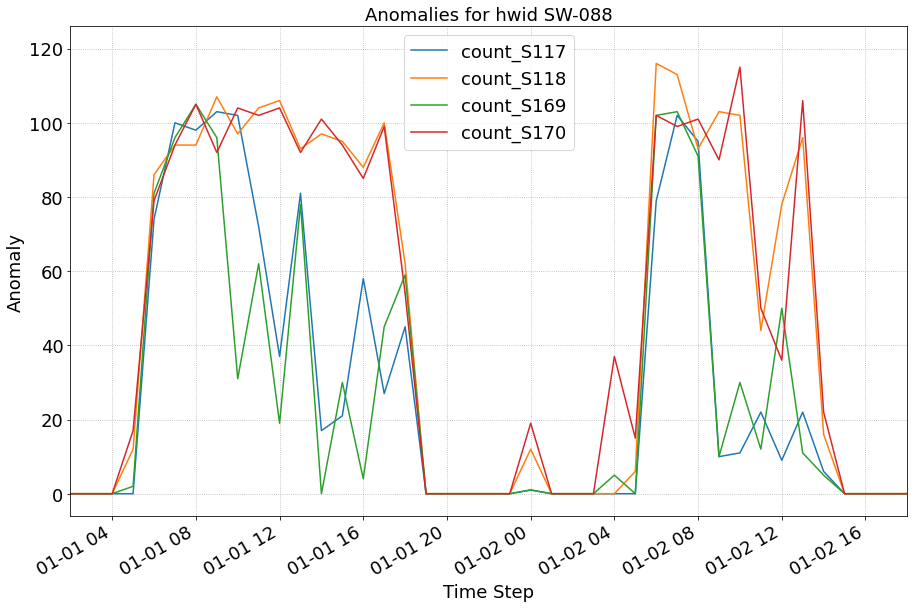

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
df_to_plot.plot(ax=ax)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left')
plt.xlim(df_to_plot.index[0],df_to_plot.index[40])
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Anomaly', fontsize=18)
ax.set_title('Anomalies for hwid SW-088', fontsize=18)
ax.grid(ls = 'dotted')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [34]:
del df_to_plot1

# Finding correlations <a class="anchor" id="corr1"></a>

After normalizing the frequncies for some metrics we look for the correlation between our anomaly metrics and the others. We use the Pearson correlation

<p align="left">
<img src="figures/pearson.jpg"  width="300"/> </p>
<p align="left">

## Correlations Hwid: SW-065

In [65]:
df_to_correlate = df_1_ex1.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_1 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

22/07/17 09:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
22/07/17 09:10:36 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Correlations Hwid: SW-088

In [66]:
df_to_correlate = df_2_ex1.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_2 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

22/07/17 09:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
22/07/17 09:10:40 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


## Correlations Hwid: SW-115

In [67]:
df_to_correlate = df_3_ex1.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_3 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

22/07/17 09:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1000.2 KiB
22/07/17 09:10:43 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


## Correlations Hwid: SW-106

In [68]:
df_to_correlate = df_4_ex1.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_4 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

22/07/17 09:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1000.2 KiB
22/07/17 09:10:49 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


### Choosing a Correlation Matrix to plot and retreive the data

Plotting a correlation matrix as an example

In [69]:
corr_matrix = corr_matrix_3

Text(0.5, 1.0, 'Correlation Matrix')

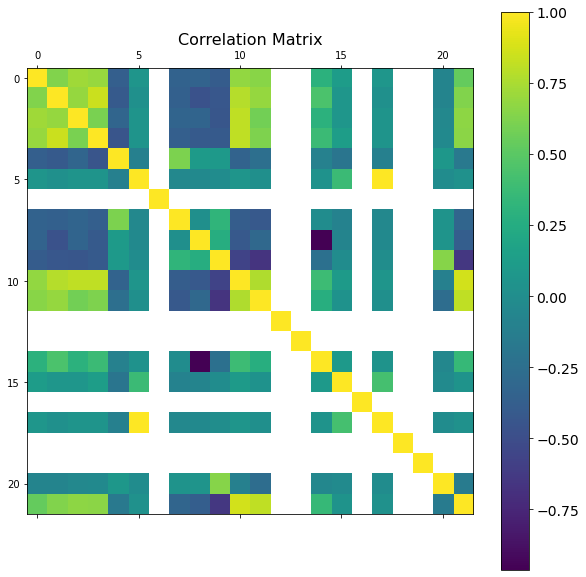

In [70]:
f = plt.figure(figsize=(10, 10))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [72]:
indexes = np.where(corr_matrix)
indexes_row = indexes[0]
indexes_col = indexes[1]

high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

correlation_df = correlation_df.dropna()

Selecting just the correlations between anomalies and metrics

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

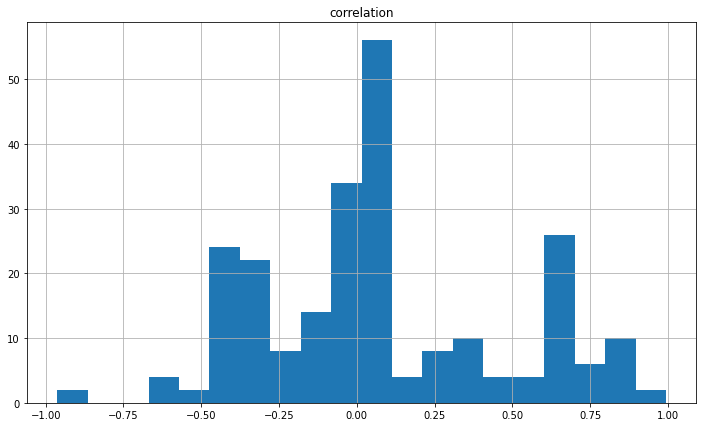

In [73]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

correlation_df.hist(bins=20, figsize= (12, 7))

In [74]:
mask_1 = ((correlation_df['metric1']=='count_S117') | (correlation_df['metric1']=='count_S118') | 
            (correlation_df['metric1']=='count_S169') | (correlation_df['metric1']=='count_S170'))
mask_2 = ((correlation_df['metric2']=='count_S117') | (correlation_df['metric2']=='count_S118') | 
            (correlation_df['metric2']=='count_S169') | (correlation_df['metric2']=='count_S170'))

correlation_df = correlation_df[mask_1 & ~mask_2]

correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
76,count_S170,S178,0.815026
54,count_S169,S178,0.809506
32,count_S118,S178,0.780348
33,count_S118,S102,0.691567
10,count_S117,S178,0.683076
65,count_S169,S164,0.668743
87,count_S170,S164,0.655314
11,count_S117,S102,0.653940
43,count_S118,S164,0.625325
77,count_S170,S102,0.621447


In [75]:
df_1_ex1.unpersist()
df_2_ex1.unpersist()
df_3_ex1.unpersist()
df_4_ex1.unpersist()

DataFrame[timestep: timestamp, count_S117: double, count_S118: double, count_S169: double, count_S170: double, S39: double, SA5: double, count_SA10: double, S10: double, S201: double, count_S172: double, S178: double, S102: double, S6: double, S106: double, S94: double, count_S8: double, SW: double, count_S7: double, count_S56: double, count_SA12: double, S143: double, S164: double]

# Assignment 2: Anomaly Detection <a class="anchor" id="anomaly2"></a>

As before, the devices in the dataset have 4 different engines which have to compress a
gas to chill or heat the environment. The percentage of working/loading of those units
is extremely important due to it could indicate problems related to under-dimensioned
or over-dimensioned devices, deterioration of some mechanical parts, or not suitable
external environment conditions. For this point, the task is:

• Identify some possible correlations between the percentage of device loading and
the external temperature
The metrics/variables that contain the information about the loading percentage of the
devices are:

• S125 (ergated capacity by circuit 1)

• S181 (ergated capacity by circuit 2)

A device can have one or both variables.


In [77]:
perc_metric = ['S125', 'S181']   #loading percentage metrics
temp_metric = ['S41']  #the external temperature metric 
metrics = ['S125', 'S181', 'S41'] #set of used metrics
timestep = '1 hours'

## Hwid: SW-065

In [78]:
%%time
df_1_ex2 = resample(df_h1, metrics_list=metrics, timestep=timestep)

df_1_ex2 = df_1_ex2.cache()
df_1_ex2.count()

CPU times: user 92.2 ms, sys: 71.6 ms, total: 164 ms
Wall time: 8.17 s


299

## Hwid: SW-088

In [79]:
%%time
df_2_ex2 = resample(df_h2, metrics_list=metrics, timestep=timestep)

df_2_ex2 = df_2_ex2.cache()
df_2_ex2.count()

CPU times: user 118 ms, sys: 74 ms, total: 192 ms
Wall time: 8.76 s


1930

## Hwid: SW-115

In [80]:
%%time
df_3_ex2 = resample(df_h3, metrics_list=metrics, timestep=timestep)

df_3_ex2 = df_3_ex2.cache()
df_3_ex2.count()

CPU times: user 123 ms, sys: 65.6 ms, total: 189 ms
Wall time: 10 s


2151

## Hwid: SW-106

In [81]:
%%time
df_4_ex2 = resample(df_h4, metrics_list=metrics, timestep=timestep)

df_4_ex2 = df_4_ex2.cache()
df_4_ex2.count()

CPU times: user 88.6 ms, sys: 84.7 ms, total: 173 ms
Wall time: 7.62 s


1098

Finding the correlation 

## Correlations Hwid: SW-065

In [84]:
df_to_correlate = df_1_ex2.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_1_ex2 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

22/07/17 09:15:07 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Correlations Hwid: SW-088

In [85]:
df_to_correlate = df_2_ex2.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_2_ex2 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

## Correlations Hwid: SW-115

In [86]:
df_to_correlate = df_3_ex2.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_3_ex2 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

## Correlations Hwid: SW-106

In [87]:
df_to_correlate = df_4_ex2.drop('time')
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# correlation matrix
corr_matrix_4_ex2 = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(dim_corr_matrix,dim_corr_matrix)

### Choosing a Correlation Matrix to plot and retreive the data

Plotting a correlation matrix as an example

In [88]:
corr_matrix = corr_matrix_2_ex2

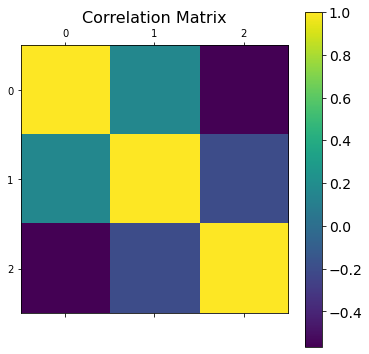

In [89]:
f = plt.figure(figsize=(6, 6))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [90]:
indexes = np.where(corr_matrix)
indexes_row = indexes[0]
indexes_col = indexes[1]

high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

correlation_df = correlation_df.dropna()
correlation_df

,metric1,metric2,correlation
0,S125,S125,1.000000
1,S125,S181,0.157473
2,S125,S41,-0.565959
3,S181,S125,0.157473
4,S181,S181,1.000000
5,S181,S41,-0.203454
6,S41,S125,-0.565959
7,S41,S181,-0.203454
8,S41,S41,1.000000


Selecting just the correlations between anomalies and metrics

In [91]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

In [92]:
correlation_df = correlation_df[(correlation_df['metric1']=='S41') & ~(correlation_df['metric2']=='S41')]

correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
7,S41,S181,-0.203454
6,S41,S125,-0.565959


In [95]:
df_1_ex2.unpersist()
df_2_ex2.unpersist()
df_3_ex2.unpersist()
df_4_ex2.unpersist()

DataFrame[timestep: timestamp, S125: double, S181: double, S41: double]

# Assignment 3: Predictive Maintenace <a class="anchor" id="predmain"></a>

As written in the previous section, variables A5 and A9 contain alarms about the devices.
More specifically, if one (or all) of the bit in positions 6, 7, and 8, of one/both the alarm/s,
are equal to 1 this means that there is/are one/some faulty/ies. In fact, if at least one of
the cited bits is at 1, it means the engines are overheating.
For this point the task is:

• Convert the alarms from their integer encoding to their bit string and then identify correctly the required alarms

• Once the alarms have been identified find some possible correlation between the variables and those alarms.

• With the figured out correlations, try to predict an alarm in the future. E.g: given
a set of correlated features (variable) at time T i−1 try to predict if at time T i there
will a fault or not.
The metrics/variables that contain the information about the alarms are:

• A5
• A9


### We consider a set of metrics which are mainly related to temperatures. Because we assume that metrics belonging to the same family (temperatures) are more correlated than a set of randomly chosed metrics

In [20]:
alarm_metric = ['A5', 'A9']
# choosing among metrics related to temperatures
metrics = ['A5', 'A9', 'S40', 'S39', 'S41', 'S3', 'S109', 'S107']

timestep = '1 hours'

### There is a total of 6 alarm event (alarm=1) in the whole dataset which all are recorded by hwid : SW-115
### Therefore we consider SW-115 hwid for this task

In [25]:
%%time
df_ex3 = resample(df_h3, metrics_list=metrics, timestep=timestep)

df_ex3 = df_ex3.cache()
df_ex3.count()

CPU times: user 515 ms, sys: 173 ms, total: 687 ms
Wall time: 35.6 s


81

In [26]:
df_ex3 = df_ex3.withColumn('Alarm', signum(col('A5') + col('A9'))).drop('A5', 'A9')

In [27]:
df_ex3.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- S40: double (nullable = true)
 |-- S39: double (nullable = true)
 |-- S41: double (nullable = true)
 |-- S3: double (nullable = true)
 |-- S109: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- Alarm: double (nullable = true)



Retreiving the epochs where alarms happen 

In [28]:
anom_timestamp = df_ex3.where(df_ex3.Alarm > 0).select('time').collect()
anom_timestamp = [timestamp[0] for timestamp in anom_timestamp]
anom_timestamp

[datetime.datetime(2021, 2, 8, 21, 0),
 datetime.datetime(2021, 2, 9, 0, 0),
 datetime.datetime(2021, 2, 9, 8, 0),
 datetime.datetime(2021, 2, 9, 1, 0),
 datetime.datetime(2021, 2, 9, 5, 0)]

## Rolling Correlation over Time

We assume that when approching the alarm time the average correlation of some metrics must vary over time. For this purpose we consider correlation on rolling windows for differnet metrics and then take the average over those metrics

<p align="left">
<img src="figures/ex_3.png"  width="650"/> </p>
<p align="left">

Defining the partitioning indeces around every alarm epoch

In [29]:
from datetime import timedelta

In [30]:
df_anom = []
i = 0
alarm_range = 100 # hours around alarm
for timestamp in anom_timestamp:
    
    start_time = timestamp - timedelta(hours=alarm_range)
    end_time = timestamp + timedelta(hours=alarm_range)
    
    df_anom.append(df_ex3.filter( (df_ex3.time > start_time) & (df_ex3.time < end_time))\
                                .withColumn('alarm_num', lit(i)))
    i+=1                                                                     

In [31]:
# union 
df_trimmed = df_anom[0]

#stacking all the dataframes realted to different alarms into one dataframe
for df in df_anom[1:]:
    df_trimmed = df_trimmed.union(df)

In [32]:
df_trimmed.groupBy('alarm_num').count().show()

+---------+-----+
|alarm_num|count|
+---------+-----+
|        0|   13|
|        1|   14|
|        2|   14|
|        3|   14|
|        4|   14|
+---------+-----+



In [33]:
#dropping unnecessary columns
col_to_corr = df_trimmed.columns
col_to_corr.remove('time')
col_to_corr.remove('Alarm')
col_to_corr.remove('alarm_num')
col_to_corr

['S40', 'S39', 'S41', 'S3', 'S109', 'S107']

Defining the columns of correlation of all the couples of metrics 

In [34]:
# create correlation over time window
df_trimmed_corr = df_trimmed
roll_window_size = -4

for col_couple in combinations(col_to_corr, 2):
    col_name = 'corr_' + col_couple[0] + '_' + col_couple[1]
    df_trimmed_corr = df_trimmed_corr.withColumn(col_name, corr(col_couple[0], col_couple[1])\
                    .over(Window.partitionBy("alarm_num").orderBy("time")\
                          .rowsBetween(roll_window_size, 0)))

In [35]:
df_trimmed_corr = df_trimmed_corr.cache()
df_trimmed_corr.count()

69

Converting the dataframe to a pandas dataframe

In [36]:
corr_over_time = df_trimmed_corr.toPandas()

In [40]:
#choosing an alarm for specifc analysis
al_num = 3 #0,3,4 5good

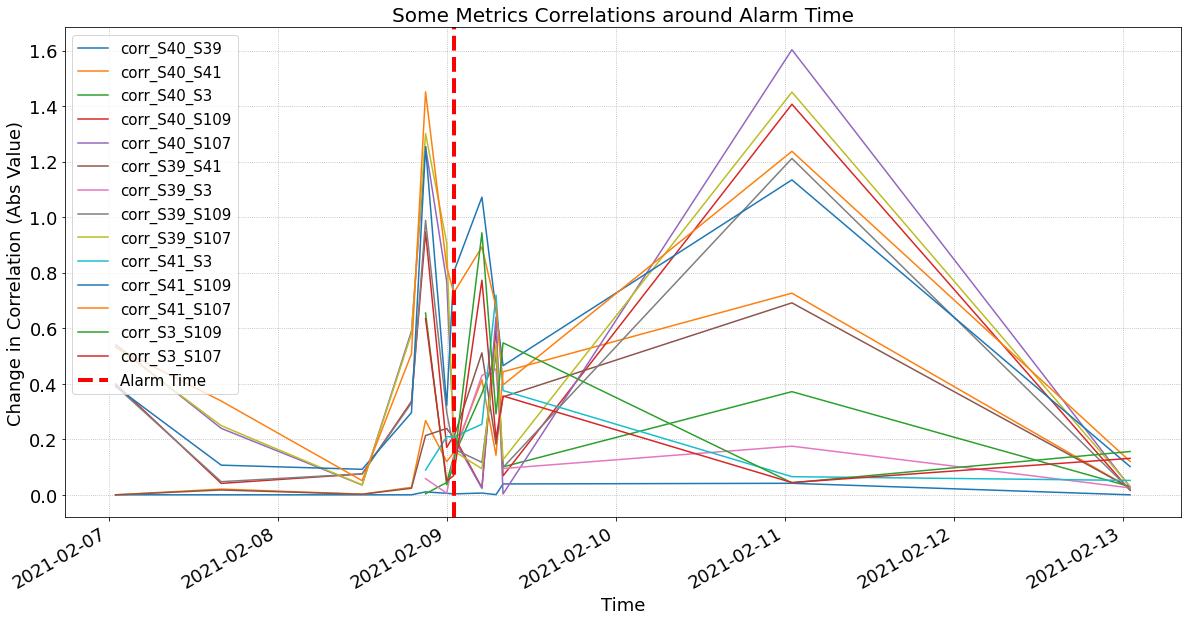

In [41]:
one_alarm = corr_over_time[corr_over_time['alarm_num'] == al_num]

# one alarm
col_corr_time = list(one_alarm.columns)
col_corr_time = [col for col in col_corr_time if col.startswith('corr')]
correlations_one = one_alarm[col_corr_time]
correlations_one = np.abs(correlations_one.diff())
correlations_one['time'] = one_alarm['time']

correlations_one.plot(x='time', y=col_corr_time[:-1], figsize=(20,10))
plt.axvline(x = anom_timestamp[al_num],ls='--',lw=4, color='red', label = 'Alarm Time')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=15)
plt.title('Some Metrics Correlations around Alarm Time', fontsize=20)
plt.ylabel('Change in Correlation (Abs Value)', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid(ls="dotted")

### Setting threshold on the change in correlation

In [251]:
cor_max

corr_S40_S39                 0.041572
corr_S40_S41                 0.726605
corr_S40_S3                   0.50524
corr_S40_S109                1.407157
corr_S40_S107                 1.60348
corr_S39_S41                 0.691619
corr_S39_S3                  0.453339
corr_S39_S109                1.211884
corr_S39_S107                1.450818
corr_S41_S3                  0.719424
corr_S41_S109                1.254566
corr_S41_S107                1.451717
corr_S3_S109                 0.943932
corr_S3_S107                 0.773302
corr_S109_S107               0.074723
time              2021-02-11 01:00:00
dtype: object

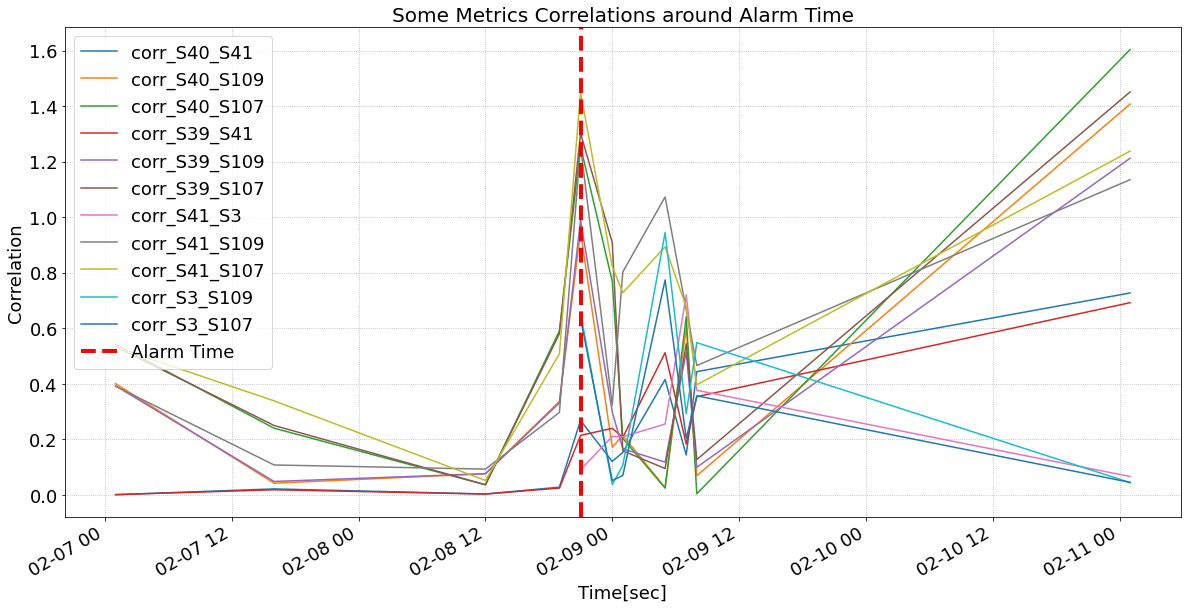

In [256]:
cor_max = correlations_one.drop('time', axis=1).max(axis=0)

cor_max_thresh = cor_max[cor_max > 0.6]

high_corr_cols = list(cor_max_thresh.index)

correlations_one.plot(x='time', y=high_corr_cols, figsize=(20,10))
plt.axvline(x = anom_epochs[al_num],ls='--',lw=4, color='red', label = 'Alarm Time')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('Some Metrics Correlations around Alarm Time', fontsize=20)
plt.ylabel('Correlation', fontsize=18)
plt.xlabel('Time[sec]', fontsize=18)
plt.grid(ls="dotted")

# Performance Test <a class="anchor" id="perf"></a>

In the last part we run a performance test in order to investigate the computation time w.r.t number of partitions and the number of cores per executors

# performance varying number of cores per executor

In [12]:
def resample(df, metrics_list, timestep): # timestep: string "n hours", "n days", "n minutes"
    
    count = 0

    for metric in metrics_list:
  
        # filter the dataset selecting one metric
        df_one_metric = df.where(col('metric') == metric).drop('metric')     


        # the resampling for the binary variable is a sum
        if metric in binary_metrics:
            
            df_to_append = (df_one_metric
                            .groupBy('time', window('time', timestep))
                            .agg(func.expr("sum(value)").alias('bucket_sum')))
            
            col_name = 'count_' + metric
            
            df_to_append = (df_to_append.select('time','window.*','bucket_sum')
                            .groupby('end')
                            .agg(func.expr("sum(bucket_sum)").alias(col_name))
                            .withColumnRenamed('end', 'time')
                           )

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
                
        elif metric in ['A5', 'A9']:
            
            map_to_16bit = udf(lambda x: '{0:016b}'.format(int(x)), StringType())
            cut_b = udf(lambda x:  int(x[5] or x[6] or x[7]), IntegerType())
            
            # converting integer to 16bit sequence
            df_one_metric = df_one_metric.withColumn('value', map_to_16bit(col('value')))
            # taking the meaningfull bits
            df_one_metric = df_one_metric.withColumn('value', cut_b(col('value')))

            df_to_append = (df_one_metric
                .groupBy('time', window('time', timestep))
                .agg(func.expr("sum(value)").alias('bucket_sum')))

            df_to_append = (df_to_append.select('time','window.*','bucket_sum')
                            .groupby('end')
                            .agg(func.expr("sum(bucket_sum)").alias(metric))
                            .withColumnRenamed('end', 'time')
                           )
            # converting to boolean again [0 -> no anomaly, 1 -> anomaly]
            df_to_append = df_to_append.withColumn(metric, signum(col(metric)).alias(metric))

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
            
        else: # the resampling for the other metrics is an average
            
            df_to_append = (df_one_metric
                            .groupBy('time', window('time', timestep))
                            .agg(func.expr("avg(value)").alias('bucket_avg')))
            
            col_name = metric
            
            df_to_append = (df_to_append.select('time','window.*','bucket_avg')
                            .groupby('end')
                            .agg(func.expr("avg(bucket_avg)").alias(col_name))
                            .withColumnRenamed('end', 'time')
                           )

            if count !=0:
                result = result.join(df_to_append, ['time'], 'inner')

            else:
                result = df_to_append
                count = 1
            
    return result

    

In [13]:
# executors [12, 6, 3]
# cores per exec [1, 2, 4] 
# time [22.827072858810425, 16.356579542160034, 15.836518049240112]

In [14]:
# get all the metrics in the dataset
all_metrics = df_h3.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)
# select a few metrics to look for correlation with anomalies
sample_metrics = S_metrics[:6]
# timestep of the reference timegrid
timestep = "1 hours"

In [15]:
ti = time.time()

df_norm3 = resample(df_h3, metrics_list=metrics, timestep=timestep)
df_norm = resample(df=df_h3, metrics_list=sample_metrics, timestep=timestep)
df_3_ex1 = df_norm.join(df_norm3, ['time'], 'inner')

df_3_ex1.count()

tf = time.time()

In [99]:
comp_time = np.array([10.45725679397583, 12.080144882202148,  15.710367441177368,18.375694751739502, 
                      21.899904251098633, 23.96292495727539,  38.66871976852417])
part_number = np.array([ 13, 7, 5, 4, 3, 2, 1])

/tmp/ipykernel_129568/1700315527.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(part_number, comp_time, '-ok', color = 'navy')


(array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

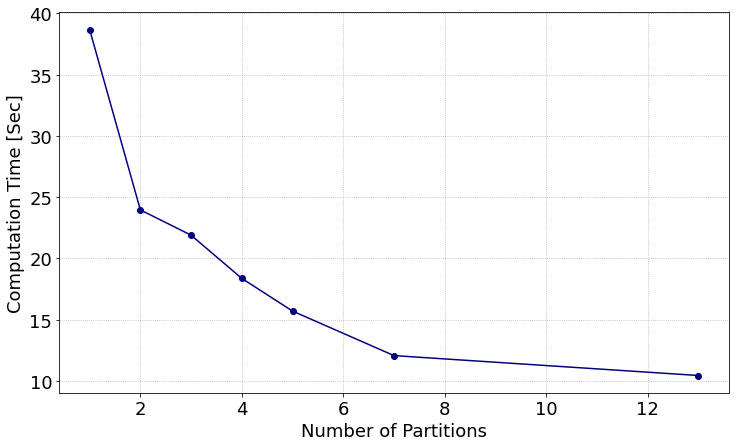

In [100]:
plt.figure(figsize=(12,7))
plt.plot(part_number, comp_time, '-ok', color = 'navy')
plt.grid(ls='dotted')
plt.xlabel('Number of Partitions', fontsize = 18)
plt.ylabel('Computation Time [Sec]',         fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

### Studying the performance varying the number of executors

In [105]:
comp_time = np.array([37.842074394226074, 32.36204957962036, 29.3])
cores_per_exec = np.array([1, 2, 4])

/tmp/ipykernel_129568/1635432735.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(cores_per_exec, comp_time, '-ok', color = 'red')


(array([28., 30., 32., 34., 36., 38., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

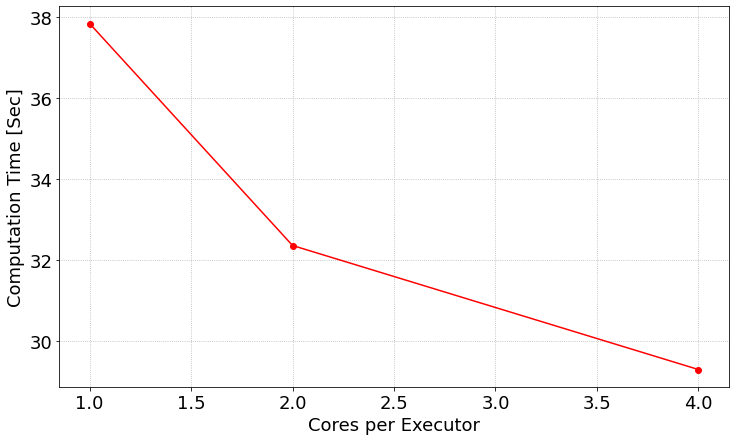

In [106]:
plt.figure(figsize=(12,7))
plt.plot(cores_per_exec, comp_time, '-ok', color = 'red')
plt.grid(ls='dotted')
plt.xlabel('Cores per Executor', fontsize = 18)
plt.ylabel('Computation Time [Sec]',         fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Conclusion  <a class="anchor" id="conc"></a>

We tried to analyze a dataset using Apache Spark running on virtual machines. We started with normalizing the frequencies, then tried to find possible correlation between different metrics and a defined anomaly metric. And at the last part we tried to define a meaningful metrics to perdict failure of the system. We managed to find some correaltions between metrics and also represented some valid prediction cases in the last part. We think that in order to find larger correaltions and more prediction oppurtunities one needs to extend the number of metrics he/she is taking into the acount

In [257]:
sc.stop()
spark.stop()